# 06__tf_tissue_sp
# calculating tissue specificity of TFs (across HepG2, HeLa, and K562)

in this notebook, i calculate the tissue specificity of TFs across the 3 cell types in our MPRAs using ENCODE RNA-seq data. then, i correlate motif coverage (# bp covered and maximum coverage) as well as average TF specificity with MPRA activities and specificities.

note: the FIMO mappings and coverage calculations were done separately (see methods)

------

figures in this notebook:
- **Fig 2C**: KDE plot of correlations of MPRA activity & specificity with each of the 3 metrics

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from scipy import signal
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def fix_small_decimal(row):
    if row.max_cov < 1:
        return 0
    else:
        return row.max_cov

In [4]:
def get_cage_id(row):
    if "Enhancer" in row.unique_id:
        return row.unique_id.split("__")[1]
    else:
        return row.unique_id.split("__")[2]

## variables

In [5]:
index_dir = "../../data/00__index"
index_f = "%s/tss_oligo_pool.index.txt" % index_dir

In [6]:
hepg2_activ_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_element.txt"
hela_activ_f = "../../data/02__activs/POOL1__pMPRA1__HeLa__activities_per_element.txt"
k562_activ_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_element.txt"

In [7]:
fimo_f = "../../misc/03__fimo/00__fimo_outputs/all_fimo_map.new_deduped.txt.gz"
fimo_chip_f = "../../misc/03__fimo/00__fimo_outputs/all_fimo_map.new_chip_intersected.new_deduped.txt.gz"
pool1_fimo_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.new_deduped.txt"
pool1_fimo_chip_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.new_chip_intersected.new_deduped.txt"
pool1_fimo_no_ets_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.no_ETS_motifs.new_deduped.txt"
pool1_fimo_no_ets_chip_f = "../../misc/03__fimo/00__fimo_outputs/pool1_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.txt"

In [8]:
# fimo_f = "../../misc/03__fimo/03__grouped_fimo_outputs/all_fimo_map.grouped.uniq.txt"
# fimo_chip_f = "../../misc/03__fimo/03__grouped_fimo_outputs/all_fimo_map.new_chip_intersected.grouped.uniq.txt"
# pool1_fimo_f = "../../misc/03__fimo/03__grouped_fimo_outputs/pool1_fimo_map.grouped.uniq.txt"
# pool1_fimo_chip_f = "../../misc/03__fimo/03__grouped_fimo_outputs/pool1_fimo_map.new_chip_intersected.grouped.uniq.txt"
# pool1_fimo_no_ets_f = "../../misc/03__fimo/03__grouped_fimo_outputs/pool1_fimo_map.grouped.no_ETS_motifs.txt"
# pool1_fimo_no_ets_chip_f = "../../misc/03__fimo/03__grouped_fimo_outputs/pool1_fimo_map.new_chip_intersected.grouped.no_ETS_motifs.txt"

In [116]:
fimo_bp_cov_f = "../../data/04__coverage/all_fimo_map.new_deduped.bp_covered.txt"
fimo_max_cov_f = "../../data/04__coverage/all_fimo_map.new_deduped.max_coverage.txt"

fimo_chip_bp_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.new_deduped.bp_covered.txt"
fimo_chip_max_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.new_deduped.max_coverage.txt"

fimo_clust_bp_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.new_deduped.bp_covered.txt"
fimo_clust_max_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.new_deduped.max_coverage.txt"

fimo_mosbat_bp_cov_f = "../../data/04__coverage/all_fimo_map.mosbat_clusters.bp_covered.txt"
fimo_mosbat_max_cov_f = "../../data/04__coverage/all_fimo_map.mosbat_clusters.max_coverage.txt"

In [10]:
fimo_no_ets_bp_cov_f = "../../data/04__coverage/all_fimo_map.no_ETS_motifs.new_deduped.bp_covered.txt"
fimo_no_ets_max_cov_f = "../../data/04__coverage/all_fimo_map.no_ETS_motifs.new_deduped.max_coverage.txt"

fimo_no_ets_chip_bp_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.bp_covered.txt"
fimo_no_ets_chip_max_cov_f = "../../data/04__coverage/all_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.max_coverage.txt"

In [11]:
pool1_fimo_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.new_deduped.bp_covered.txt"
pool1_fimo_max_cov_f = "../../data/04__coverage/pool1_fimo_map.new_deduped.max_coverage.txt"

pool1_fimo_chip_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.new_deduped.bp_covered.txt"
pool1_fimo_chip_max_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.new_deduped.max_coverage.txt"

In [12]:
pool1_fimo_no_ets_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.no_ETS_motifs.new_deduped.bp_covered.txt"
pool1_fimo_no_ets_max_cov_f = "../../data/04__coverage/pool1_fimo_map.no_ETS_motifs.new_deduped.max_coverage.txt"

pool1_fimo_no_ets_chip_bp_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.bp_covered.txt"
pool1_fimo_no_ets_chip_max_cov_f = "../../data/04__coverage/pool1_fimo_map.new_chip_intersected.no_ETS_motifs.new_deduped.max_coverage.txt"

In [13]:
tf_ts_f = "../../data/04__coverage/TF_tissue_specificities.from_CAGE.txt"

In [14]:
cage_v_mpra_f = "../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt"

In [15]:
tss_cage_map_f = "../../misc/00__tss_properties/mpra_tss_detailed_info.txt"
enh_cage_map_f = "../../misc/00__tss_properties/enhancer_id_map.txt"

## 1. import data

In [16]:
fimo = pd.read_table(fimo_f, sep="\t", header=None, compression="gzip")
fimo.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", "end", 
                "motif", "motif_score", "motif_strand"]
fimo.head()

,motif_chr,motif_start,motif_end,unique_id,score,strand,chr,start,end,motif,motif_score,motif_strand
0,chr1,564441,564452,"intergenic__NA__chr1:564474..564492,-",0,-,chr1,564441,564452,ESRRB,15.29310,-
1,chr1,564442,564453,"intergenic__NA__chr1:564474..564492,-",0,-,chr1,564442,564453,Esrra,11.83640,-
2,chr1,564442,564452,"intergenic__NA__chr1:564474..564492,-",0,-,chr1,564442,564452,Esrrg,14.87760,-
3,chr1,564442,564450,"intergenic__NA__chr1:564474..564492,-",0,-,chr1,564442,564450,NR4A2,11.74750,-
4,chr1,564451,564462,"intergenic__NA__chr1:564474..564492,-",0,-,chr1,564451,564462,Esrra,6.36364,+


In [17]:
fimo_chip = pd.read_table(fimo_chip_f, sep="\t", header=None, compression="gzip")
fimo_chip.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", "end", 
                     "motif", "motif_score", "motif_strand"]

In [18]:
pool1_fimo = pd.read_table(pool1_fimo_f, sep="\t", header=None)
pool1_fimo.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", "end", 
                      "motif", "motif_score", "motif_strand"]

In [19]:
pool1_fimo_chip = pd.read_table(pool1_fimo_chip_f, sep="\t", header=None)
pool1_fimo_chip.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", 
                           "end", "motif", "motif_score", "motif_strand"]

In [20]:
pool1_fimo_no_ets = pd.read_table(pool1_fimo_no_ets_f, sep="\t", header=None)
pool1_fimo_no_ets.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", "start", 
                             "end", "motif", "motif_score", "motif_strand"]

In [21]:
pool1_fimo_no_ets_chip = pd.read_table(pool1_fimo_no_ets_chip_f, sep="\t", header=None)
pool1_fimo_no_ets_chip.columns = ["motif_chr", "motif_start", "motif_end", "unique_id", "score", "strand", "chr", 
                                  "start", "end", "motif", "motif_score", "motif_strand"]

In [22]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "oligo_type", "unique_id", "dupe_info", "SNP", "seq_name"]]
index_elem = index_elem.drop_duplicates()

In [23]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")

In [24]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [25]:
fimo_bp_cov = pd.read_table(fimo_bp_cov_f, sep="\t", header=None)
fimo_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                       "frac_bp_cov"]

fimo_max_cov = pd.read_table(fimo_max_cov_f, sep="\t", header=None)
fimo_max_cov.columns = ["unique_id", "max_cov"]

fimo_cov = fimo_bp_cov.merge(fimo_max_cov, on="unique_id")
print(len(fimo_cov))
fimo_cov.head()

56578


,chr,start,end,unique_id,score,strand,n_motifs,n_bp_cov,seq_len,frac_bp_cov,max_cov
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,19,66,115,0.573913,7
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,26,91,115,0.791304,9
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,25,78,115,0.678261,8
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,21,89,115,0.773913,8
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,36,93,115,0.808696,13


In [26]:
fimo_no_ets_bp_cov = pd.read_table(fimo_no_ets_bp_cov_f, sep="\t", header=None)
fimo_no_ets_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", 
                              "seq_len", "frac_bp_cov"]

fimo_no_ets_max_cov = pd.read_table(fimo_no_ets_max_cov_f, sep="\t", header=None)
fimo_no_ets_max_cov.columns = ["unique_id", "max_cov"]

fimo_no_ets_cov = fimo_no_ets_bp_cov.merge(fimo_no_ets_max_cov, on="unique_id")
print(len(fimo_no_ets_cov))

56571


In [27]:
fimo_no_ets_chip_bp_cov = pd.read_table(fimo_no_ets_chip_bp_cov_f, sep="\t", header=None)
fimo_no_ets_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", 
                                   "seq_len", "frac_bp_cov"]

fimo_no_ets_chip_max_cov = pd.read_table(fimo_no_ets_chip_max_cov_f, sep="\t", header=None)
fimo_no_ets_chip_max_cov.columns = ["unique_id", "max_cov"]

fimo_no_ets_chip_cov = fimo_no_ets_chip_bp_cov.merge(fimo_no_ets_chip_max_cov, on="unique_id")
print(len(fimo_no_ets_chip_cov))

39609


In [28]:
fimo_chip_bp_cov = pd.read_table(fimo_chip_bp_cov_f, sep="\t", header=None)
fimo_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                            "frac_bp_cov"]

fimo_chip_max_cov = pd.read_table(fimo_chip_max_cov_f, sep="\t", header=None)
fimo_chip_max_cov.columns = ["unique_id", "max_cov"]

fimo_chip_cov = fimo_chip_bp_cov.merge(fimo_chip_max_cov, on="unique_id")
print(len(fimo_chip_cov))

40375


In [29]:
fimo_clust_bp_cov = pd.read_table(fimo_clust_bp_cov_f, sep="\t", header=None)
fimo_clust_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                             "frac_bp_cov"]

fimo_clust_max_cov = pd.read_table(fimo_clust_max_cov_f, sep="\t", header=None)
fimo_clust_max_cov.columns = ["unique_id", "max_cov"]

fimo_clust_cov = fimo_clust_bp_cov.merge(fimo_clust_max_cov, on="unique_id")
print(len(fimo_clust_cov))

35108


In [117]:
fimo_mosbat_bp_cov = pd.read_table(fimo_mosbat_bp_cov_f, sep="\t", header=None)
fimo_mosbat_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                             "frac_bp_cov"]

fimo_mosbat_max_cov = pd.read_table(fimo_mosbat_max_cov_f, sep="\t", header=None)
fimo_mosbat_max_cov.columns = ["unique_id", "max_cov"]

fimo_mosbat_cov = fimo_clust_bp_cov.merge(fimo_mosbat_max_cov, on="unique_id")
print(len(fimo_mosbat_cov))

56530


In [30]:
pool1_fimo_bp_cov = pd.read_table(pool1_fimo_bp_cov_f, sep="\t", header=None)
pool1_fimo_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", "seq_len", 
                             "frac_bp_cov"]

pool1_fimo_max_cov = pd.read_table(pool1_fimo_max_cov_f, sep="\t", header=None)
pool1_fimo_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_cov = pool1_fimo_bp_cov.merge(pool1_fimo_max_cov, on="unique_id")
print(len(pool1_fimo_cov))

4660


In [31]:
pool1_fimo_chip_bp_cov = pd.read_table(pool1_fimo_chip_bp_cov_f, sep="\t", header=None)
pool1_fimo_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", 
                                  "seq_len", "frac_bp_cov"]

pool1_fimo_chip_max_cov = pd.read_table(pool1_fimo_chip_max_cov_f, sep="\t", header=None)
pool1_fimo_chip_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_chip_cov = pool1_fimo_chip_bp_cov.merge(pool1_fimo_chip_max_cov, on="unique_id")
print(len(pool1_fimo_chip_cov))

4348


In [32]:
pool1_fimo_no_ets_bp_cov = pd.read_table(pool1_fimo_no_ets_bp_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", "n_bp_cov", 
                                    "seq_len", "frac_bp_cov"]

pool1_fimo_no_ets_max_cov = pd.read_table(pool1_fimo_no_ets_max_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_no_ets_cov = pool1_fimo_no_ets_bp_cov.merge(pool1_fimo_no_ets_max_cov, on="unique_id")
print(len(pool1_fimo_no_ets_cov))

4660


In [33]:
pool1_fimo_no_ets_chip_bp_cov = pd.read_table(pool1_fimo_no_ets_chip_bp_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_chip_bp_cov.columns = ["chr", "start", "end", "unique_id", "score", "strand", "n_motifs", 
                                         "n_bp_cov", "seq_len", "frac_bp_cov"]

pool1_fimo_no_ets_chip_max_cov = pd.read_table(pool1_fimo_no_ets_chip_max_cov_f, sep="\t", header=None)
pool1_fimo_no_ets_chip_max_cov.columns = ["unique_id", "max_cov"]

pool1_fimo_no_ets_chip_cov = pool1_fimo_no_ets_chip_bp_cov.merge(pool1_fimo_no_ets_chip_max_cov, on="unique_id")
print(len(pool1_fimo_no_ets_chip_cov))

4319


In [118]:
all_cov_dfs = {"fimo": fimo_cov, "fimo_chip": fimo_chip_cov, "fimo_clust": fimo_clust_cov, 
               "fimo_no_ets": fimo_no_ets_cov, "fimo_no_ets_chip": fimo_no_ets_chip_cov, 
               "pool1_fimo": pool1_fimo_cov, "pool1_fimo_chip": pool1_fimo_chip_cov, 
               "pool1_fimo_no_ets": pool1_fimo_no_ets_cov, 
               "pool1_fimo_no_ets_chip": pool1_fimo_no_ets_chip_cov,
               "fimo_mosbat": fimo_mosbat_cov}

all_motif_dfs = {"fimo": fimo, "fimo_chip": fimo_chip, "pool1_fimo": pool1_fimo, "pool1_fimo_chip": pool1_fimo_chip,
                 "pool1_fimo_no_ets": pool1_fimo_no_ets, "pool1_fimo_no_ets_chip": pool1_fimo_no_ets_chip}

In [119]:
for key in all_cov_dfs.keys():
    df = all_cov_dfs[key]
    df["max_cov"] = df.apply(fix_small_decimal, axis=1)
    df["log_n_motifs"] = np.log(df["n_motifs"]+1)
    df["log_bp_cov"] = np.log(df["n_bp_cov"]+1)
    df["log_max_cov"] = np.log(df["max_cov"]+1)
    df["cage_id"] = df.apply(get_cage_id, axis=1)

fimo_chip_cov.head()

,chr,start,end,unique_id,score,strand,n_motifs,n_bp_cov,seq_len,frac_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,cage_id
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,3,26,115,0.226087,1,1.386294,3.295837,0.693147,"chr10:100027943..100027958,-"
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,5,25,115,0.217391,2,1.791759,3.258097,1.098612,chr10:100074404-100074582
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,2,22,115,0.191304,1,1.098612,3.135494,0.693147,chr10:100076038-100076149
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,6,53,115,0.460870,3,1.945910,3.988984,1.386294,chr10:100076500-100076699
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,10,74,115,0.643478,2,2.397895,4.317488,1.098612,chr10:100082942-100083374


In [36]:
for key in all_motif_dfs.keys():
    df = all_motif_dfs[key]
    df["cage_id"] = df.apply(get_cage_id, axis=1)
    
fimo.sample(5)

,motif_chr,motif_start,motif_end,unique_id,score,strand,chr,start,end,motif,motif_score,motif_strand,cage_id
922439,chr6,14556372,14556383,Enhancer__chr6:14556348-14556398,0,+,chr6,14556372,14556383,Spz1,15.11820,-,chr6:14556348-14556398
400745,chr16,28506915,28506924,"protein_coding__p@chr16:28506840..28506942,-__...",0,-,chr16,28506915,28506924,THAP1,9.76316,-,"chr16:28506840..28506942,-"
700219,chr20,62612429,62612440,protein_coding__p1@PRPF6__chr20:62612470..6261...,0,+,chr20,62612429,62612440,Klf1,13.65150,-,"chr20:62612470..62612516,+"
934872,chr6,31802365,31802375,protein_coding__p2@C6orf48__chr6:31802364..318...,0,+,chr6,31802365,31802375,MEOX2,10.51490,+,"chr6:31802364..31802419,+"
855356,chr5,1295199,1295216,"protein_coding__p1@TERT__chr5:1295153..1295192,-",0,-,chr5,1295199,1295216,SP4,11.45450,-,"chr5:1295153..1295192,-"


In [37]:
tf_ts = pd.read_table(tf_ts_f, sep="\t")
tf_ts.head()

,tf,tissue_sp_all,tissue_sp_3,K562_exp,HeLa_exp,HepG2_exp
0,PAX7,0.990032,NaN,0.000000,0.000000,0.000000
1,HNF1B,0.979589,0.666667,0.000000,0.000000,5.889702
2,LIN54,0.794230,0.412303,17.857032,18.290625,47.369957
3,IRF3,0.719361,0.089475,23.938784,29.128210,26.498907
4,MEF2C,0.978378,0.665278,112.089652,0.335948,0.131145


In [38]:
cage_v_mpra = pd.read_table(cage_v_mpra_f, sep="\t")
cage_v_mpra["oligo_reg"] = cage_v_mpra["unique_id"].str.split("__", expand=True)[2]
cage_v_mpra.head()

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,0.786378,0.665068,1.400056,0.142230,"chr10:11936664..11936778,-"
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,0.377764,0.151243,-0.054568,0.214384,"chr10:28821597..28821711,-"
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,1.258762,0.158191,1.378850,0.118103,"chr10:29698406..29698520,+"
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,0.938897,0.140302,0.130581,0.269957,"chr10:97667625..97667739,-"
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,div_lnc,0.465003,0.292028,3.046316,0.085757,"chr11:27528316..27528430,+"


In [39]:
tss_cage_map = pd.read_table(tss_cage_map_f, sep="\t")
tss_cage_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [40]:
enh_cage_map = pd.read_table(enh_cage_map_f, sep="\t")
enh_cage_map.head()

,enhancer_id,TSS_id_Neg,TSS_id_Pos,distTSSs,sum_1828_samples,avExpALL,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,avExpCS,oligo_reg_Neg,oligo_reg_Pos
0,chr1:1004646-1004986,"chr1:1004724..1004725,-","chr1:1004806..1004807,+",239,2186.660,1.196204,1.75865,1.718966,0.0,0.278501,0.634142,0.471889,0.224833,0.0,0.193772,0.586750,"chr1:1004690..1004804,-","chr1:1004727..1004841,+"
1,chr1:108483614-108484145,"chr1:108483919..108483920,-","chr1:108484014..108484015,+",706,949.696,0.519527,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108483885..108483999,-","chr1:108483935..108484049,+"
2,chr1:108592862-108593109,"chr1:108592862..108592863,-","chr1:108592945..108592946,+",84,1794.280,0.981554,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108592828..108592942,-","chr1:108592866..108592980,+"
3,chr1:109099158-109099479,"chr1:109099171..109099172,-","chr1:109099303..109099304,+",159,1366.590,0.747588,0.00000,0.000000,0.0,0.000000,0.000000,0.078648,0.000000,0.0,0.000000,0.008739,"chr1:109099137..109099251,-","chr1:109099224..109099338,+"
4,chr1:109788948-109789150,"chr1:109788975..109788976,-","chr1:109789149..109789150,+",229,2093.390,1.145181,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:109788941..109789055,-","chr1:109789070..109789184,+"


## 2. for pool1: join coverage and motif files with MPRA expr/spec files

In [41]:
# since enhancers have 2 TSS_ids, need to join these separately
tmp = cage_v_mpra.merge(tss_cage_map[["oligo_reg", "TSS_id"]], on="oligo_reg", how="left")
tmp_enh_pos = tmp[(tmp["unique_id"].str.contains("Enhancer")) & (tmp["TSS_id"].str[-1] == "+")]
tmp_enh_neg = tmp[(tmp["unique_id"].str.contains("Enhancer")) & (tmp["TSS_id"].str[-1] == "-")]

tmp_enh_pos = tmp_enh_pos.merge(enh_cage_map[["TSS_id_Pos", "enhancer_id"]], left_on="TSS_id", right_on="TSS_id_Pos",
                                how="left")
tmp_enh_neg = tmp_enh_neg.merge(enh_cage_map[["TSS_id_Neg", "enhancer_id"]], left_on="TSS_id", right_on="TSS_id_Neg",
                                how="left")
tmp_enh_pos = tmp_enh_pos.drop("TSS_id_Pos", axis=1)
tmp_enh_neg = tmp_enh_neg.drop("TSS_id_Neg", axis=1)
tmp_enh = tmp_enh_pos.append(tmp_enh_neg)
tmp_enh["TSS_id"] = tmp_enh["enhancer_id"]
tmp_enh.drop("enhancer_id", axis=1, inplace=True)
tmp_enh.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
206,WILDTYPE__Enhancer.noflip.NA__chr1:12493563..1...,Enhancer,0.168249,0.666667,-0.629874,0.106798,"chr1:12493563..12493677,+",chr1:12493313-12493712
177,WILDTYPE__Enhancer.noflip.NA__chr14:107252984....,Enhancer,0.093420,0.654228,-0.748350,0.122480,"chr14:107252984..107253098,-",chr14:107252931-107253417
138,WILDTYPE__Enhancer.flip.sense__chr20:62495643....,Enhancer,0.612572,0.388677,-0.239213,0.062955,"chr20:62495643..62495757,-",chr20:62494990-62495823
275,WILDTYPE__Enhancer.noflip.NA__chr9:114823651.....,Enhancer,0.000000,NaN,0.890422,0.184299,"chr9:114823651..114823765,-",chr9:114823556-114823978
194,WILDTYPE__Enhancer.noflip.NA__chr17:42276716.....,Enhancer,0.453821,0.321153,2.156577,0.041673,"chr17:42276716..42276830,-",chr17:42276572-42276897


In [42]:
tmp_no_enh = tmp[~tmp["unique_id"].str.contains("Enhancer")]
cage_v_mpra = tmp_no_enh.append(tmp_enh)
cage_v_mpra.sample(5)

,unique_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
1928,WILDTYPE__mrna.noflip.NA__chr14:21737581..2173...,protein_coding,0.252017,0.190416,0.541260,0.184693,"chr14:21737581..21737695,-","chr14:21737610..21737621,-"
141,WILDTYPE__Enhancer.flip.sense__chr21:17568001....,Enhancer,0.077185,0.666667,-2.399441,0.319314,"chr21:17568001..17568115,+",chr21:17568022-17568137
474,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr5:...,intergenic,0.472852,0.436474,0.482987,0.074187,"chr5:90610184..90610298,-","chr5:90610209..90610226,-"
264,WILDTYPE__Enhancer.noflip.NA__chr7:44677809..4...,Enhancer,0.137360,0.666667,-0.937127,0.334636,"chr7:44677809..44677923,+",chr7:44677628-44678244
136,WILDTYPE__Enhancer.flip.sense__chr1:236080869....,Enhancer,0.004412,0.666667,-1.498062,0.353825,"chr1:236080869..236080983,+",chr1:236080566-236081247


In [43]:
pool1_fimo_cov = pool1_fimo_cov.merge(cage_v_mpra, on="unique_id")
pool1_fimo = pool1_fimo.merge(cage_v_mpra, on="unique_id")
pool1_fimo_cov["cage_id"] = pool1_fimo_cov["TSS_id"]
pool1_fimo["cage_id"] = pool1_fimo["TSS_id"]
all_cov_dfs["pool1_fimo"] = pool1_fimo_cov
all_motif_dfs["pool1_fimo"] = pool1_fimo
print(len(pool1_fimo_cov))
pool1_fimo_cov.sample(5)

2076


,chr,start,end,unique_id,score,strand,n_motifs,n_bp_cov,seq_len,frac_bp_cov,...,log_bp_cov,log_max_cov,cage_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
1571,chr5,77656156,77656270,WILDTYPE__Lincrna.noflip.NA__chr5:77656156..77...,1,-,11,55,114,0.482456,...,4.025352,1.791759,"chr5:77656175..77656253,-",div_lnc,0.458273,0.311285,-2.204394,0.323584,"chr5:77656156..77656270,-","chr5:77656175..77656253,-"
84,chr10,80008510,80008624,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr10...,1,+,6,33,114,0.289474,...,3.526361,1.609438,"chr10:80008582..80008616,+",intergenic,0.000000,NaN,-2.459223,0.416605,"chr10:80008510..80008624,+","chr10:80008582..80008616,+"
1895,chr8,58658608,58658722,WILDTYPE__Lincrna.noflip.NA__chr8:58658608..58...,1,+,8,38,114,0.333333,...,3.663562,1.609438,"chr8:58658679..58658697,+",intergenic,0.000000,NaN,-2.563233,0.240908,"chr8:58658608..58658722,+","chr8:58658679..58658697,+"
1917,chr8,86851854,86851968,WILDTYPE__Lincrna.noflip.NA__chr8:86851854..86...,1,+,28,74,114,0.649123,...,4.317488,2.708050,"chr8:86851932..86851934,+",intergenic,0.125736,0.666667,-0.980339,0.382936,"chr8:86851854..86851968,+","chr8:86851932..86851934,+"
1427,chr4,183065036,183065150,WILDTYPE__mrna.flip.sense__chr4:183065036..183...,1,+,34,72,114,0.631579,...,4.290459,2.484907,"chr4:183065109..183065122,+",protein_coding,0.050640,0.666667,-1.321383,0.414410,"chr4:183065036..183065150,+","chr4:183065109..183065122,+"


In [44]:
pool1_fimo_chip_cov = pool1_fimo_chip_cov.merge(cage_v_mpra, on="unique_id")

# for old chip files:
#pool1_fimo_chip = pool1_fimo_chip.drop("unique_id", axis=1).merge(cage_v_mpra, left_on="cage_id", right_on="TSS_id")

# for new chip files:
pool1_fimo_chip = pool1_fimo_chip.merge(cage_v_mpra, on="unique_id")

pool1_fimo_chip_cov["cage_id"] = pool1_fimo_chip_cov["TSS_id"]
pool1_fimo_chip["cage_id"] = pool1_fimo_chip["TSS_id"]
all_cov_dfs["pool1_fimo_chip"] = pool1_fimo_chip_cov
all_motif_dfs["pool1_fimo_chip"] = pool1_fimo_chip
print(len(pool1_fimo_chip_cov))

1926


In [45]:
pool1_fimo_no_ets_cov = pool1_fimo_no_ets_cov.merge(cage_v_mpra, on="unique_id")
pool1_fimo_no_ets = pool1_fimo_no_ets.merge(cage_v_mpra, on="unique_id")
pool1_fimo_no_ets_cov["cage_id"] = pool1_fimo_no_ets_cov["TSS_id"]
pool1_fimo_no_ets["cage_id"] = pool1_fimo_no_ets["TSS_id"]
all_cov_dfs["pool1_fimo_no_ets"] = pool1_fimo_no_ets_cov
all_motif_dfs["pool1_fimo_no_ets"] = pool1_fimo_no_ets
print(len(pool1_fimo_no_ets_cov))

2076


In [46]:
pool1_fimo_no_ets_chip_cov = pool1_fimo_no_ets_chip_cov.merge(cage_v_mpra, on="unique_id")

# for old chip files:
# pool1_fimo_no_ets_chip = pool1_fimo_no_ets_chip.drop("unique_id", axis=1).merge(cage_v_mpra, left_on="cage_id", 
#                                                                                 right_on="TSS_id")

# for new chip files:
pool1_fimo_no_ets_chip = pool1_fimo_no_ets_chip.merge(cage_v_mpra, on="unique_id")

pool1_fimo_no_ets_chip_cov["cage_id"] = pool1_fimo_no_ets_chip_cov["TSS_id"]
pool1_fimo_no_ets_chip["cage_id"] = pool1_fimo_no_ets_chip["TSS_id"]
all_cov_dfs["pool1_fimo_no_ets_chip"] = pool1_fimo_no_ets_chip_cov
all_motif_dfs["pool1_fimo_no_ets_chip"] = pool1_fimo_no_ets_chip
print(len(pool1_fimo_no_ets_chip_cov))

1912


In [47]:
pool1_fimo_no_ets_chip.head()

,motif_chr,motif_start,motif_end,unique_id,score,strand,chr,start,end,motif,motif_score,motif_strand,cage_id,PromType2,cage_activ,cage_ts,mpra_activ,mpra_ts,oligo_reg,TSS_id
0,chr1,713979,713991,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,713979,713991,E2F1,11.96720,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
1,chr1,713979,713991,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,713979,713991,E2F1,11.55740,+,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
2,chr1,714030,714041,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,714030,714041,SP1,10.48080,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
3,chr1,714030,714045,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,714030,714045,SP2,10.44830,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"
4,chr1,714052,714069,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,0,-,chr1,714052,714069,SP4,7.27273,-,"chr1:713985..714054,-",intergenic,0.975524,0.155088,1.227084,0.153124,"chr1:713977..714091,-","chr1:713985..714054,-"


## 3. find avg TF/motif specificity per tile

In [48]:
all_spec_dfs = {}
for key in all_motif_dfs.keys():
    print(key)
    df = all_motif_dfs[key]
    df["motif"] = df["motif"].str.upper()
    df = df.merge(tf_ts, left_on="motif", right_on="tf", how="left")
    df_nonan = df[~pd.isnull(df["tissue_sp_3"])]
    df_deduped = df_nonan.drop_duplicates(subset=["motif", "unique_id"])
    avg_sp = df_deduped.groupby(["cage_id"])["tissue_sp_3"].agg("mean").reset_index()
    avg_sp.columns = ["cage_id", "avg_tf_tissue_sp"]
    avg_sp["log_avg_tf_tissue_sp"] = np.log(avg_sp["avg_tf_tissue_sp"]+1)
    all_spec_dfs[key] = avg_sp
avg_sp.sample(5)

fimo
fimo_chip
pool1_fimo
pool1_fimo_chip
pool1_fimo_no_ets
pool1_fimo_no_ets_chip


,cage_id,avg_tf_tissue_sp,log_avg_tf_tissue_sp
723,"chr1:81106951..81107001,+",0.349090,0.299430
826,"chr22:20004247..20004282,-",0.368958,0.314050
522,chr18:60903713-60904052,0.413074,0.345767
717,"chr1:713985..714054,-",0.367494,0.312980
1003,"chr3:112738490..112738533,-",0.454805,0.374872


## 4. merge and write coverage files

In [120]:
file_prefixes = {"fimo": "all_fimo_map", "fimo_chip": "all_fimo_map.chip_intersected", 
                 "fimo_clust": "all_fimo_map.bulyk_clusters", "fimo_no_ets": "all_fimo_map.no_ETS_motifs",
                 "fimo_no_ets_chip": "all_fimo_map.chip_intersected.no_ETS_motifs", 
                 "pool1_fimo": "pool1_fimo_map", "pool1_fimo_chip": "pool1_fimo_map.chip_intersected", 
                 "pool1_fimo_no_ets": "pool1_fimo_map.no_ETS_motifs", 
                 "pool1_fimo_no_ets_chip": "pool1_fimo_map.chip_intersected.no_ETS_motifs",
                 "fimo_mosbat": "all_fimo_map.mosbat_clusters"}

for key in all_cov_dfs.keys():
    print(key)
    name = file_prefixes[key]
    cov_df = all_cov_dfs[key]
    if key in all_spec_dfs.keys():
        spec_df = all_spec_dfs[key]
        merge_df = cov_df.merge(spec_df, on="cage_id", how="left")
        merge_df = merge_df[["unique_id", "cage_id", "n_motifs", "n_bp_cov", "max_cov", "avg_tf_tissue_sp", 
                             "log_n_motifs", "log_bp_cov", "log_max_cov", "log_avg_tf_tissue_sp"]].drop_duplicates()
    else:
        merge_df = cov_df[["unique_id", "cage_id", "n_motifs", "n_bp_cov", "max_cov", 
                                 "log_n_motifs", "log_bp_cov", "log_max_cov"]].drop_duplicates()
    
    merge_df.to_csv("../../data/04__coverage/%s.all_cov.new.txt" % name, sep="\t", index=False)
    
    if "pool1" in name:
        merge_df = merge_df.merge(cage_v_mpra[["unique_id", "mpra_activ", "mpra_ts"]], on="unique_id")
    all_cov_dfs[key] = merge_df

fimo
fimo_chip
fimo_clust
fimo_no_ets
fimo_no_ets_chip
pool1_fimo
pool1_fimo_chip
pool1_fimo_no_ets
pool1_fimo_no_ets_chip
fimo_mosbat


## 5. plot correlations w/ MPRA data

## tissue specificity

#### fimo only

In [50]:
df = all_cov_dfs["pool1_fimo"]
df.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,mpra_activ,mpra_ts
0,WILDTYPE__mrna.noflip.NA__chr10:102046079..102...,"chr10:102046098..102046122,-",13,39,11,0.417349,2.639057,3.688879,2.484907,0.348788,0.755234,0.339882
1,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr10...,"chr10:102133377..102133394,+",18,61,5,0.444224,2.944439,4.127134,1.791759,0.367572,-1.257574,0.401928
2,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr10:1...,"chr10:1034365..1034411,+",31,77,11,0.391036,3.465736,4.356709,2.484907,0.330049,0.480824,0.144071
3,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr10:10...,"chr10:104597163..104597180,-",10,78,3,0.452162,2.397895,4.369448,1.386294,0.373054,-1.168195,0.270406
4,WILDTYPE__Lincrna.noflip.NA__chr10:106113294.....,"chr10:106113320..106113338,-",25,65,13,0.408014,3.258097,4.189655,2.639057,0.342180,0.412117,0.107425


In [51]:
#cmap = sns.light_palette("#8da0cb", as_cmap=True)
cmap = sns.light_palette("darkslategray", as_cmap=True)

In [52]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_activ"])]
len(no_nan)

2047

r: -0.194622411683, spearman p: 6.38254121464e-19


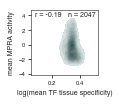

In [53]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
fig.savefig("Fig_2C_3.fimo_only.pdf", bbox_inches="tight", dpi="figure")

In [54]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_ts"])]
len(no_nan)

1956

r: 0.174477337355, spearman p: 7.76830099959e-15


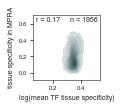

In [55]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
fig.savefig("Fig_2C_6.fimo_only.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [56]:
df = all_cov_dfs["pool1_fimo_chip"]

In [57]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_activ"])]
len(no_nan)

1887

r: -0.0926340154874, spearman p: 5.57799593204e-05


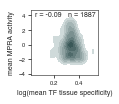

In [58]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
fig.savefig("Fig_2C_3.chip_int.pdf", bbox_inches="tight", dpi="figure")

In [59]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_ts"])]
len(no_nan)

1798

r: 0.119866943369, spearman p: 3.44074606519e-07


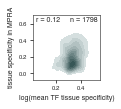

In [60]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
fig.savefig("Fig_2C_6.chip_int.pdf", bbox_inches="tight", dpi="figure")

#### fimo only -- no ETS

In [61]:
df = all_cov_dfs["pool1_fimo_no_ets"]

In [62]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_activ"])]
len(no_nan)

2047

r: -0.164969818496, spearman p: 5.87602458173e-14


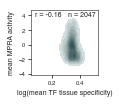

In [63]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#fig.savefig("Fig_2C_3.pdf", bbox_inches="tight", dpi="figure")

In [64]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_ts"])]
len(no_nan)

1956

r: 0.145735281035, spearman p: 9.42668471969e-11


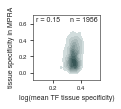

In [65]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
#fig.savefig("Fig_2C_6.pdf", bbox_inches="tight", dpi="figure")

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#### fimo intersected w/ chip -- no ETS

In [66]:
df = all_cov_dfs["pool1_fimo_no_ets_chip"]

In [67]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_activ"])]
len(no_nan)

1871

r: -0.0405957996325, spearman p: 0.0791697534308


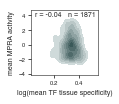

In [68]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [69]:
no_nan = df[~pd.isnull(df["log_avg_tf_tissue_sp"]) &
            ~pd.isnull(df["mpra_ts"])]
len(no_nan)

1782

r: 0.0744770739895, spearman p: 0.00165452139633


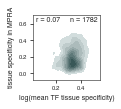

In [70]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(no_nan["log_avg_tf_tissue_sp"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

## number of bp covered

#### fimo only

In [71]:
df = all_cov_dfs["pool1_fimo"]

In [72]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

2050

r: 0.285490951836, spearman p: 9.52518428583e-40


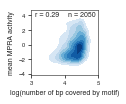

In [73]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_xlim((3,5))

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_1.fimo_only.pdf", bbox_inches="tight", dpi="figure")

In [74]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1959

r: -0.165931840763, spearman p: 1.45899177146e-13


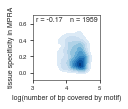

In [75]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_xlim((3, 5))

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_4.fimo_only.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [76]:
df = all_cov_dfs["pool1_fimo_chip"]

In [77]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1899

r: 0.466227983786, spearman p: 4.29077318116e-103


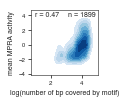

In [78]:
fig = plt.figure(figsize=(1.2, 1.2))
no_0 = no_nan[no_nan["n_bp_cov"] > 0]
all_0 = no_nan[no_nan["n_bp_cov"] == 0]
ax = sns.kdeplot(no_0["log_bp_cov"], no_0["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_1.chip_int.pdf", bbox_inches="tight", dpi="figure")

In [79]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1810

r: -0.310352568139, spearman p: 1.03997426937e-41


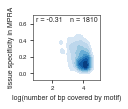

In [80]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_4.chip_int.pdf", bbox_inches="tight", dpi="figure")

#### fimo only -- no ETS motifs

In [81]:
df = all_cov_dfs["pool1_fimo_no_ets"]

In [82]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

2050

r: 0.276516763784, spearman p: 2.67851040066e-37


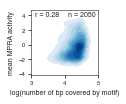

In [83]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_xlim((3,5))

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
#fig.savefig("Fig_2C_1.pdf", bbox_inches="tight", dpi="figure")

In [84]:
no_nan = pool1_fimo_no_ets_cov[~pd.isnull(pool1_fimo_no_ets_cov["log_bp_cov"]) &
                               ~pd.isnull(pool1_fimo_no_ets_cov["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1959

r: -0.157694535918, spearman p: 2.23208258772e-12


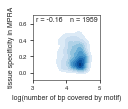

In [85]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")
ax.set_xlim((3, 5))

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)
#fig.savefig("Fig_2C_4.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip -- no ETS motifs

In [86]:
df = all_cov_dfs["pool1_fimo_no_ets_chip"]

In [87]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1885

r: 0.448219291357, spearman p: 8.14229399272e-94


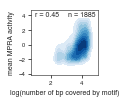

In [88]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_activ"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [89]:
no_nan = df[~pd.isnull(df["log_bp_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1796

r: -0.295346570007, spearman p: 1.76381064527e-37


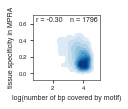

In [90]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_bp_cov"], no_nan["mpra_ts"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(no_nan["log_bp_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

## max overlapping coverage

#### fimo only

In [91]:
df = all_cov_dfs["pool1_fimo"]

In [92]:
cmap = sns.light_palette("firebrick", as_cmap=True)

In [93]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

2050

r: 0.363203310073, spearman p: 5.91007117938e-65


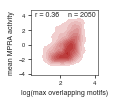

In [94]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_2.fimo_only.pdf", bbox_inches="tight", dpi="figure")

In [95]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1959

r: -0.280937064449, spearman p: 7.36699080159e-37


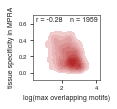

In [96]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_5.fimo_only.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip

In [97]:
df = all_cov_dfs["pool1_fimo_chip"]

In [98]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1899

r: 0.444130555558, spearman p: 1.2818580762e-92


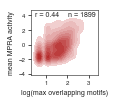

In [99]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_2.chip_int.pdf", bbox_inches="tight", dpi="figure")

In [100]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1810

r: -0.340141195812, spearman p: 2.93513951774e-50


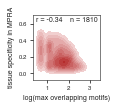

In [101]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

fig.savefig("Fig_2C_5.chip_int.pdf", bbox_inches="tight", dpi="figure")

#### fimo only -- no ETS motifs

In [102]:
df = all_cov_dfs["pool1_fimo_no_ets"]

In [103]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

2050

r: 0.341923650029, spearman p: 2.62358814372e-57


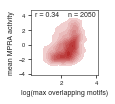

In [104]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#fig.savefig("Fig_2C_2.pdf", bbox_inches="tight", dpi="figure")

In [105]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1959

r: -0.257536951596, spearman p: 4.77064346326e-31


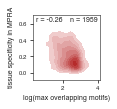

In [106]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

#fig.savefig("Fig_2C_5.pdf", bbox_inches="tight", dpi="figure")

#### fimo intersected w/ chip -- no ETS motifs

In [107]:
df = all_cov_dfs["pool1_fimo_no_ets_chip"]

In [108]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_activ"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1885

r: 0.397359515303, spearman p: 2.49215932399e-72


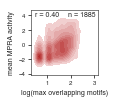

In [109]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_activ"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_activ"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [110]:
df.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,mpra_activ,mpra_ts
1511,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr6:17...,"chr6:170102210..170102275,+",31,80,8,0.450476,3.465736,4.394449,2.197225,0.371892,2.888511,0.098397
605,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,"chr15:48624043..48624074,-",23,52,6,0.510594,3.178054,3.970292,1.945910,0.412503,-0.252398,0.409715
315,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr12:10...,"chr12:108956355..108956403,+",16,58,5,0.417367,2.833213,4.077537,1.791759,0.348801,2.549090,0.057908
1300,WILDTYPE__mrna.flip.sense__chr4:1242883..12429...,"chr4:1242871..1242942,-",12,61,4,0.295359,2.564949,4.127134,1.609438,0.258788,1.444348,NaN
1226,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr3:186...,"chr3:186435111..186435126,+",9,23,4,0.334482,2.302585,3.178054,1.609438,0.288543,-1.369763,0.260906


In [111]:
no_nan = df[~pd.isnull(df["log_max_cov"]) &
            ~pd.isnull(df["mpra_ts"])]

# for these, only look at those with >1 motif
no_nan = no_nan[no_nan["n_motifs"] > 0]
len(no_nan)

1796

r: -0.297005164054, spearman p: 6.6759691729e-38


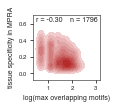

In [112]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(no_nan["log_max_cov"], no_nan["mpra_ts"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(max overlapping motifs)")

r, p = stats.spearmanr(no_nan["log_max_cov"], no_nan["mpra_ts"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)

# add n-value
ax.annotate("n = %s" % len(no_nan), ha="right", xy=(.96, .9), xycoords=ax.transAxes, 
            fontsize=fontsize)

In [113]:
df.max_cov.max()

16

In [114]:
df = all_cov_dfs["pool1_fimo_chip"]
df.sort_values(by="max_cov", ascending=False).head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,mpra_activ,mpra_ts
154,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr11:18...,"chr11:18344088..18344105,+",57,85,21,0.383495,4.060443,4.454347,3.091042,0.324613,1.675244,0.049422
155,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr11:18...,"chr11:18344106..18344128,+",49,65,21,0.365188,3.912023,4.189655,3.091042,0.311292,0.882740,0.073824
595,WILDTYPE__mrna.flip.sense__chr15:40331342..403...,"chr15:40331356..40331387,-",31,83,16,0.421783,3.465736,4.430817,2.833213,0.351912,2.784371,0.047920
159,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr11:2...,"chr11:207342..207414,-",44,82,15,0.470147,3.806662,4.418841,2.772589,0.385362,2.139812,0.128026
606,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,"chr15:45571414..45571433,-",17,41,15,0.373059,2.890372,3.737670,2.772589,0.317041,2.054229,0.067425


In [115]:
df.iloc[1575].unique_id

'WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr6:42946923..42947037,-__1670.1.0.0'